<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

<font color='green'>Цель</font>

Построить модель для предсказания количество заказов такси. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<font color='green'>Задачи</font>

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<font color='green'>Файлы</font>

- `taxi.csv` 

<font color='green'>Целевой признак</font>

- `num_orders` - кол-во заказов такси.

## Подготовка

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error              

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor

import shap
import os

In [3]:
pth1 = '/ML/datasets/taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')
    
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Проверим наличие пропусков.

In [6]:
data.isnull().sum()

num_orders    0
dtype: int64

Проверим наличие дубликатов.

In [7]:
data[data.index.duplicated(keep=False)]

,num_orders
datetime,


**Вывод**

Данные загружены. Пропуски и дубликаты не выявлены.

## Анализ

Создадим скользящее среднее для наших данных.

In [8]:
data['rolling_mean'] = data['num_orders'].shift().rolling(12).mean()
data = data.dropna()
decomposed = seasonal_decompose(data['num_orders'])

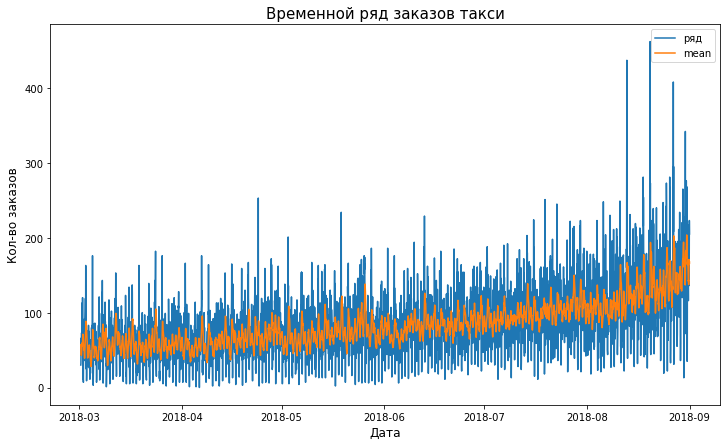

In [9]:
plt.figure(figsize=(12, 7))
sns.lineplot(x=data.index, y='num_orders', data=data, label='ряд')
sns.lineplot(x=data.index, y='rolling_mean', data=data, label='mean')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кол-во заказов', fontsize=12)
plt.title('Временной ряд заказов такси', fontsize=15);

Посмотрим на остаток декомпозиции временного ряда.

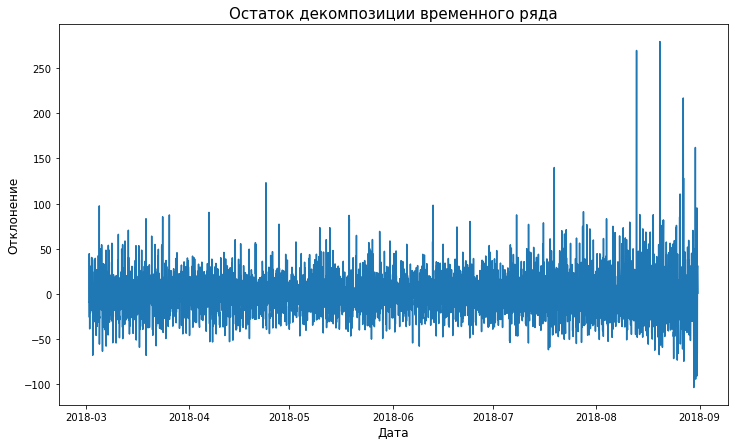

In [10]:
plt.figure(figsize=(12, 7))
sns.lineplot(x=data.index, y=decomposed.resid, data=decomposed)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Отклонение', fontsize=12)
plt.title('Остаток декомпозиции временного ряда', fontsize=15);

Остатки ведут себя достаточно стабильно. Есть выбросы в конце периода.

Проверим гипотезу о стационарности временного ряда c помощью теста Дики-Фуллера (ADF).

- **$H_0$** (нулевая гипотеза): временной ряд не стационарен.
- **$H_1$** (альтернативная гипотеза): временной ряд стационарен.

In [11]:
result = adfuller(data['num_orders'])
print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])
print('Критические значения с разными доверительными интервалами:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] < result[4][key]:
        print ('Нулевая гипотеза отвергнута – Временной ряд стационарен')
    else:
        print ('Нулевая гипотеза не отвергнута – Временной ряд не стационарен')

Критерий ADF: -3.035768
P-значение: 0.031686
Критические значения с разными доверительными интервалами:
	1%: -3.432
Нулевая гипотеза не отвергнута – Временной ряд не стационарен
	5%: -2.862
Нулевая гипотеза отвергнута – Временной ряд стационарен
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


Критический уровень статистической значимости 5% и выше позволяет говорить нам о том, что ряд стационарен.

Посмотрим на тренд и сезонность.

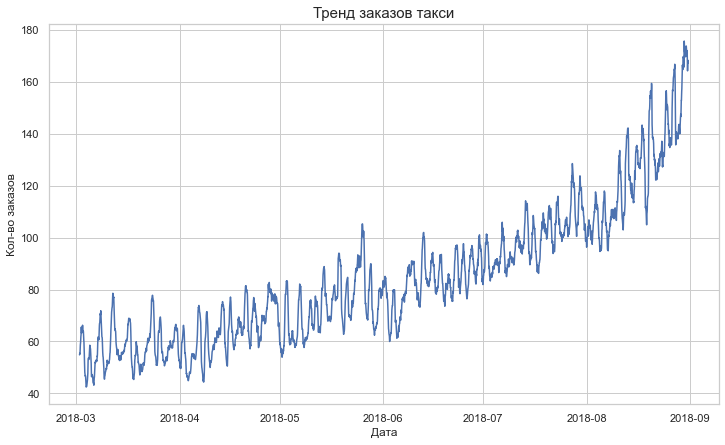

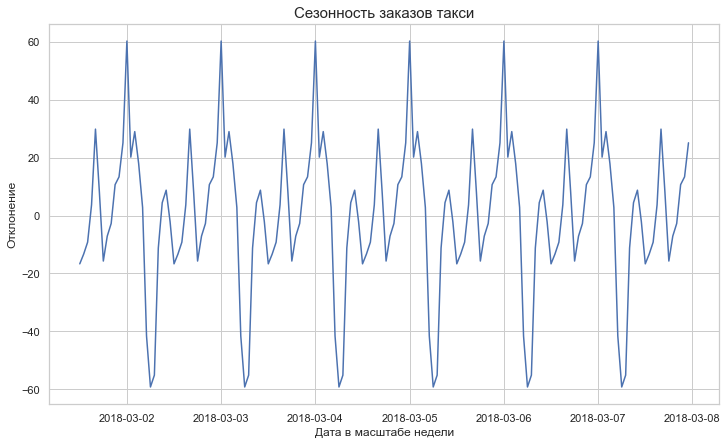

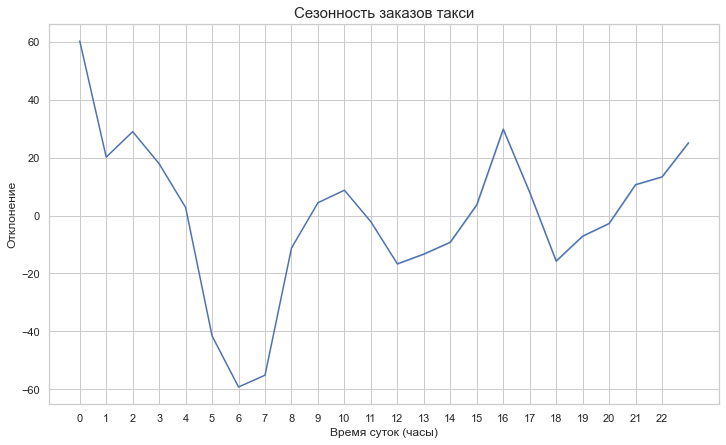

In [12]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))
sns.lineplot(x=data.index, y=decomposed.trend, data=decomposed)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кол-во заказов', fontsize=12)
plt.title('Тренд заказов такси', fontsize=15)

plt.figure(figsize=(12, 7))
sns.lineplot(x=data['2018-03-01':'2018-03-07'].index, y=decomposed.seasonal['2018-03-01':'2018-03-07'], data=decomposed)
plt.xlabel('Дата в масштабе недели', fontsize=12)
plt.ylabel('Отклонение', fontsize=12)
plt.title('Сезонность заказов такси', fontsize=15)

plt.figure(figsize=(12, 7))
sns.lineplot(x=data['2018-03-01':'2018-03-02'].index.hour, y=decomposed.seasonal['2018-03-01':'2018-03-02'], data=decomposed)
plt.xlabel('Время суток (часы)', fontsize=12)
plt.ylabel('Отклонение', fontsize=12)
plt.title('Сезонность заказов такси', fontsize=15)
plt.xticks(range(23));

Наблюдается общий восходящий тренд и цикличность периодом в 1 сутки. 
С учётом суточного характера сезонности, максимум заказов наблюдается в районе 0:00, минимум - в районе 6:00. Подобная картина, вероятно, связана с графиком работы метро и аэроэкспрессов/автобусов. Часть пассажиров выбирает такси при отсутствии возможности воспользоваться альтернативным транспортом. Локальные минимумы в 12.00 и в 18.00 могут быть связаны как с временем обеда/ужина, так и с расписанием рейсов с самых популярных направлений.

**Вывод**

Критический уровень статистической значимости 5% и выше позволяет говорить о стационарности рассматриваемого ряда.
В ходе анализа также выявлены:
  
  - общий восходящий тренд;
  - цикличность периодом в 1 сутки.

## Обучение

Учитывая, что данные о заказах такси есть за период с марта 2018 по август 2018 включительно, cоздадим новые признаки.

In [13]:
def make_features(data, max_lag):
    df = data.copy()
    
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    return df

df = make_features(data, 7)

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
y_train = train['num_orders']
X_train = train.drop('num_orders', axis=1)
y_test = test['num_orders']
X_test = test.drop('num_orders', axis=1)

In [16]:
regressions = [
                LinearRegression(),
                RandomForestRegressor(random_state = 12345),
                CatBoostRegressor(verbose=False, random_state = 12345),
                DecisionTreeRegressor(random_state = 12345)
              ]

regressions_dict = {0: 'LinearRegression',
                    1: 'Random Forest',
                    2: 'CatBoost',
                    3: 'DecisionTree'}

param = {
             0:{},
    
             1:{'max_depth' : range (3,9),
                'max_features': range (1,11,1)},
    
             2:{'learning_rate': [0.001,0.01,0.1],
                'depth': [2,4,6],
                'iterations': range(900,1500,100)},
    
             3:{'max_depth' : range(3, 9),
                'max_features': range(1,11,1)}   
        }


best_rmse = 48.0
best_param = 0
best_model = ''
best_model_index = ''
index = 0

for reg in regressions:
    
    tscv = TimeSeriesSplit(n_splits=3)
    model = GridSearchCV(estimator=reg, param_grid=param[index], scoring='neg_mean_squared_error', cv=tscv) 
    model.fit(X_train, y_train)
    rmse = (-1*model.best_score_)**0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_index = regressions_dict[index]
        best_model = reg
        best_param = model.best_params_
        
    print('\nМодель: {}'.format(regressions_dict[index]))
    print('Лучшие параметры : {}'.format(model.best_params_))
    print('Лучшее значение RMSE на train: {:.4f}'.format(rmse))
    
    index += 1
    
print('\nМодель с лучшим значением RMSE на train: {}'.format(best_model_index))
print('Параметры лучшей модели:', best_param)


Модель: LinearRegression
Лучшие параметры : {}
Лучшее значение RMSE на train: 33.7812

Модель: Random Forest
Лучшие параметры : {'max_depth': 8, 'max_features': 8}
Лучшее значение RMSE на train: 28.5464

Модель: CatBoost
Лучшие параметры : {'depth': 4, 'iterations': 1400, 'learning_rate': 0.01}
Лучшее значение RMSE на train: 27.2781

Модель: DecisionTree
Лучшие параметры : {'max_depth': 7, 'max_features': 10}
Лучшее значение RMSE на train: 31.6116

Модель с лучшим значением RMSE на train: CatBoost
Параметры лучшей модели: {'depth': 4, 'iterations': 1400, 'learning_rate': 0.01}


**Вывод**

In [17]:
print('\nМодель с лучшим значением RMSE на train: {}'.format(best_model_index))
print('RMSE на train:  {:.4f}'.format(best_rmse))
print('Параметры лучшей модели:', best_param)


Модель с лучшим значением RMSE на train: CatBoost
RMSE на train:  27.2781
Параметры лучшей модели: {'depth': 4, 'iterations': 1400, 'learning_rate': 0.01}


## Тестирование

Проверим лучшую модель на test.

In [18]:
model = CatBoostRegressor(depth=6, iterations=1400, learning_rate=0.01, verbose=False)
model.fit(X_train, y_train)
predicted_test = model.predict(X_test)
print('RMSE лучшей модели на test:  {:.4f}'.format(mean_squared_error(y_test, predicted_test, squared=False)))

explainer = shap.Explainer(model)

shap_values_1 = explainer(X_train)
shap_values_2 = shap.TreeExplainer(model).shap_values(X_train)

RMSE лучшей модели на test:  45.2954


Проверим модель на адекватность, сравнив с исскуственной.

In [19]:
strategies = ['mean', 'median']

for strategy in strategies:

    baseline_model = DummyRegressor(strategy=strategy)
    baseline_model.fit(X_train, y_train)

    predicted = baseline_model.predict(X_test)
    
    print('\nСтратегия модели:', strategy)
    print('RMSE модели на test:  {:.4f}'.format(mean_squared_error(y_test, predicted, squared=False)))


Стратегия модели: mean
RMSE модели на test:  84.7431

Стратегия модели: median
RMSE модели на test:  87.2421


Необходимый порог для RMSE достигнут. Модель прошла проверку на адекватность. Посмотрим на важность признаков.

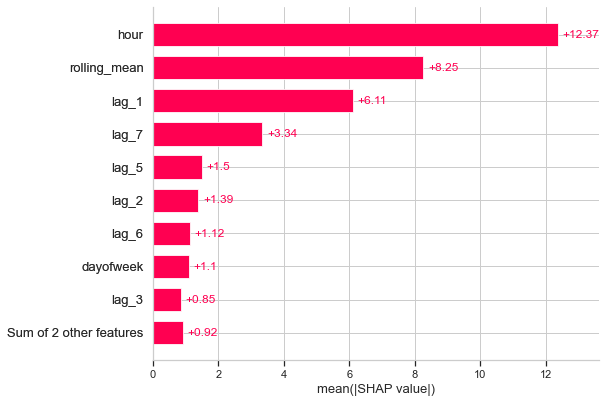

In [20]:
shap.plots.bar(shap_values_1)

Топ 3 важных признаков модели:
    
    - время заказа (час)
    - скользящее среднее
    - предыдущее значение ряда
    
Посмотрим на них подробнее.

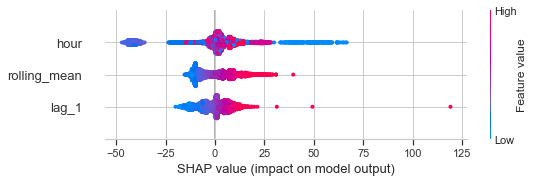

In [21]:
shap.summary_plot(shap_values_2, X_train, max_display=3, plot_size='auto')

    Чем краснее точки на графике, тем выше значения признака в ней.
    Чем толще линия на графике, тем больше таких точек наблюдения. 

- время заказа (час): нелинейная зависимость, максимальное кол-во заказов в час приходится на ночное время, минимальное - на утро.  
- скользящее среднее: значение этого признака прямопропорционально значению целевого признака.
- предыдущее значение ряда: значение этого признака прямопропорционально значению целевого признака.

Результат работы модели.

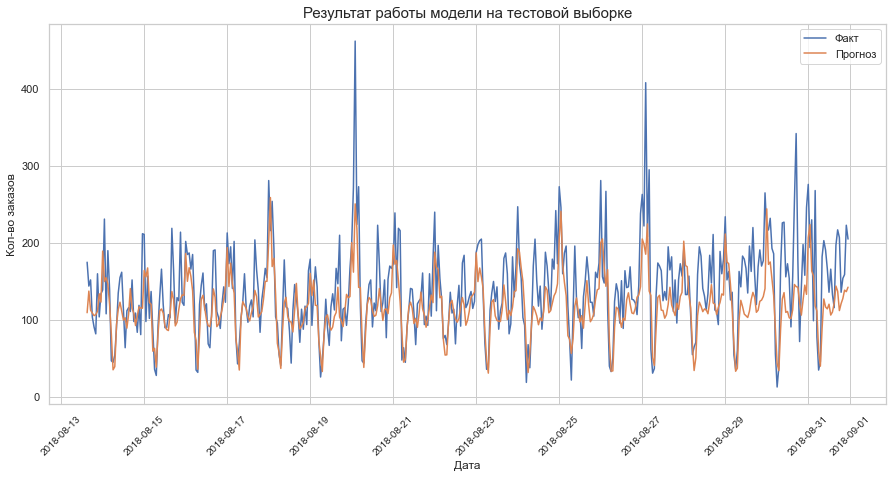

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Факт')
plt.plot(pd.Series(predicted_test, index=y_test.index), label='Прогноз')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кол-во заказов', fontsize=12)
plt.title('Результат работы модели на тестовой выборке', fontsize=15)
plt.xticks(fontsize=10, rotation=45)
plt.legend()
plt.show()

В целом, модель предсказывает меньшее кол-во заказов чем фактические данные.

**Вывод**

В ходе анализа временного ряда заказов такси выявлены общий восходящий тренд и цикличность  периодом в 1 сутки.

In [23]:
print('\nМодель с лучшим значением RMSE на train: {}'.format(best_model_index))
print('RMSE на test:  {:.4f}'.format(mean_squared_error(y_test, predicted_test, squared=False)))
print('Параметры лучшей модели:', best_param)


Модель с лучшим значением RMSE на train: CatBoost
RMSE на test:  45.2954
Параметры лучшей модели: {'depth': 4, 'iterations': 1400, 'learning_rate': 0.01}


Топ 3 важных признаков модели:
    
    - время заказа (час)
    - скользящее среднее
    - предыдущее значение ряда